In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

from pydftlj.dft import DFT

from pymatgen.core import Structure

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2024-10-03

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
structure_name = 'IRMOF-1'
structure = Structure.from_file('structures/'+structure_name+'.cif')
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn32 H96 C192 O104
num_sites: 424


In [4]:
coordinates = structure.cart_coords.T
L = structure.lattice.lengths
Vcell = L[0]*L[1]*L[2]
print(L)

(25.86584, 25.86584, 25.86584)


# Force Field for solid-fluid interaction

In [5]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

/tmp/ipykernel_309648/3440480918.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  forcefield = pd.read_csv('parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)


,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,F,3.09320,36.48345,18.99800
5,Al,3.91104,155.99820,26.98150
6,Si,3.80414,155.99820,28.08550
7,Br,3.51905,186.19140,79.90400
8,Cu,3.11369,2.51610,63.54600
9,Zn,4.04468,27.67710,65.38000


# Create the DFT object

In [6]:
DFTMFA = DFT(ndim=3,functional='aWBI+MFA')
DFTWDA = DFT(ndim=3,functional='aWBI+WDA')
DFTMMFA = DFT(ndim=3,functional='aWBI+MMFA')

DFTs = [DFTMFA,DFTWDA,DFTMMFA]

In [7]:
Ngrid = 32

## Fluid Information (CH4)

_References_:
- PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
- TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
- SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.

In [8]:
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043

rcut = 5*sigmaff

In [9]:
#Helium parameters for pycnometer
epsilonHe = 10.22 # kelvin
sigmaHe = 2.58  # angstrom

In [10]:
for DFT in DFTs:
    DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff,cut_off=rcut)

In [11]:
for DFT in DFTs:
    # DFT.Set_Number_of_Gridpoints(number_gridpoints=Ngrid)
    DFT.Set_Gridsize(gridsize=0.25*sigmaff)
    DFT.Set_Geometry(box_dimensions=L)

In [12]:
Ngrid = DFTMMFA.Ngrid[0]

## Setting the Temperature

In [13]:
kT = 300.0 # kelvin (kB = 1)

In [14]:
for DFT in DFTs:
    DFT.Set_Temperature(kT)

## Generating the External Potential from Solid Structure

In [15]:
def lj_potential(r,sigma,epsilon):
    return np.where(r>5*sigma,0.0,4.0*epsilon*((sigma/r)**12-(sigma/r)**6))

In [16]:
# %%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))
Vext_helium = np.zeros((Ngrid,Ngrid,Ngrid))

X, Y, Z = DFTMFA.X, DFTMFA.Y, DFTMFA.Z

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmas = float(forcefield["sigma/AA"][forcefield["atom"]==site.species_string])
    epsilons = float(forcefield["epsilon/kB"][forcefield["atom"]==site.species_string])
    
    sigmasf = 0.5*(sigmaff+sigmas)
    epsilonsf = np.sqrt(epsilonff*epsilons)
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    rx = X - structure.cart_coords[i,0]
    ry = Y - structure.cart_coords[i,1]
    rz = Z - structure.cart_coords[i,2]
    rx -= L[0]*(rx/L[0]).round() #periodic BC
    ry -= L[1]*(ry/L[1]).round() #periodic BC
    rz -= L[2]*(rz/L[2]).round() #periodic BC

    R = np.sqrt(rx**2 + ry**2 + rz**2+1e-16) # to avoid zero
    Vext[:] += lj_potential(R,sigmasf,epsilonsf)

    sigmasHe = 0.5*(sigmaHe+sigmas)
    epsilonsHe = np.sqrt(epsilonHe*epsilons)

    Vext_helium[:] += lj_potential(R,sigmasHe,epsilonsHe)

del R

for DFT in DFTs:
    DFT.Set_External_Potential(Vext)

/tmp/ipykernel_309648/1080849254.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmas = float(forcefield["sigma/AA"][forcefield["atom"]==site.species_string])
/tmp/ipykernel_309648/1080849254.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilons = float(forcefield["epsilon/kB"][forcefield["atom"]==site.species_string])
/tmp/ipykernel_309648/1080849254.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])


In [17]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999966  u


In [18]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [19]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923836  kg/m3


In [20]:
Vpore_calc = np.exp(-Vext_helium/kT).sum()*DFTMMFA.dV
helium_fraction = Vpore_calc/Vcell

print(f'Calculated pore volume for He atom is {Vpore_calc} A³')
print(f'Calculated He void fraction is {helium_fraction:1.3f}')

Calculated pore volume for He atom is 14422.620671469307 A³
Calculated He void fraction is 0.833


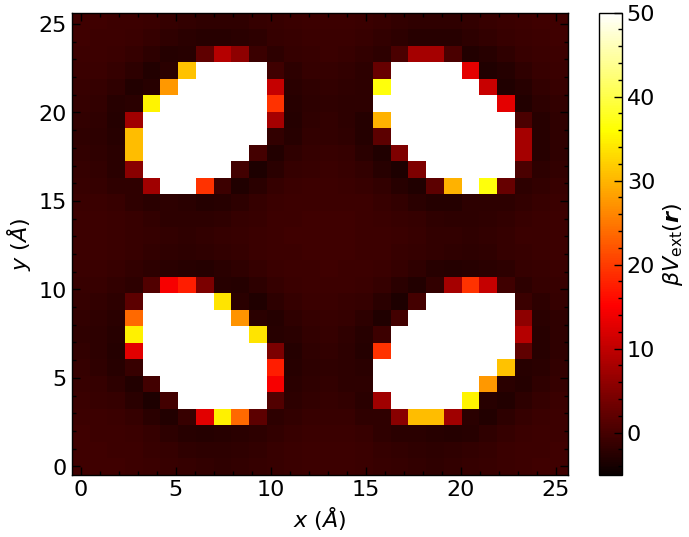

In [21]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFTMMFA.X[:,:,DFTMMFA.Ngrid[2]//2],DFTMMFA.Y[:,:,DFTMMFA.Ngrid[2]//2],DFTMMFA.beta*DFTMMFA.Vext[:,:,DFTMMFA.Ngrid[2]//2].cpu(), cmap='hot',vmin=-5,vmax=50)
plt.colorbar(label=r'$\beta V_\text{ext}(\boldsymbol{r})$')
plt.xlabel(r'$x$ ($\AA$)')
plt.ylabel(r'$y$ ($\AA$)')
plt.show()

In [22]:
rhobarray = torch.pow(10.0,torch.arange(-6,-1.95,0.05))
pbarray = DFTMMFA.ljeos.p(rhobarray,kT)*(1e-5*kB)/1e-30 # pressure in bar

pbarrange = np.hstack((np.arange(0.1,1.0,0.1),np.arange(1.,10,1.0),np.arange(10.,100,2.0),np.arange(100,510,10.0))) # bulk pressure (in bar)
rhobrange = np.interp(pbarrange, pbarray.numpy(), rhobarray.numpy())

Text(0, 0.5, '$\\rho_b$ (molecules/$\\AA^{3}$)')

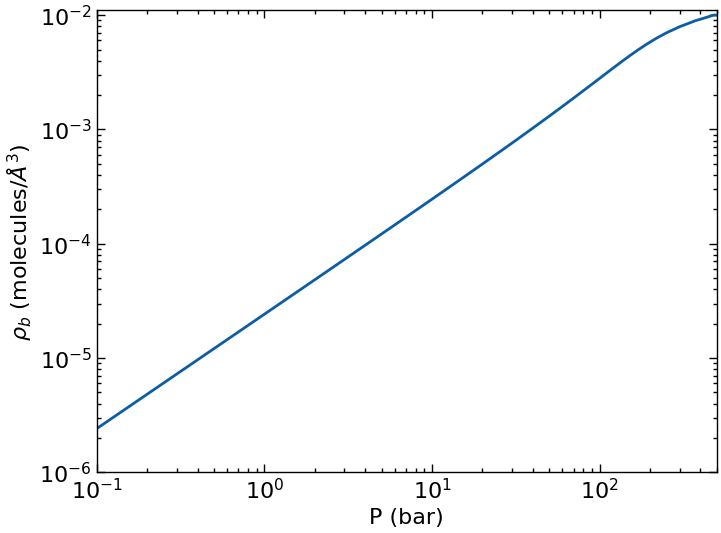

In [23]:
plt.plot(pbarrange,rhobrange)
plt.xlim(0.1,500)
plt.ylim(1e-6,0.011)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho_b$ (molecules/$\AA^{3}$)')

In [59]:
%%time

Nabsarray = np.zeros((len(DFTs),rhobrange.size)) # Absolute adsorbed quantity
Nexcarray = np.zeros((len(DFTs),rhobrange.size)) # Excess adsorbed quantity

for DFT in DFTs:
    DFT.Set_BulkDensity(rhobrange[0].item())
    DFT.Set_InitialCondition(model='bulk')
    DFT.Set_Solver_Equilibrium(solver='abc-fire',alpha=0.15,dt=0.01)

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)\t Nexc(molecules/u.c.)')

for i in range(rhobrange.size):
    rhob = rhobrange[i].item()

    for d, DFT in enumerate(DFTs):
        DFT.Set_BulkDensity(rhob)
        DFT.Calculate_Equilibrium()

        Nabsarray[d,i] = DFT.Nabs 
        Nexcarray[d,i] = DFT.Nabs - DFT.rhob*Vpore_calc

    print(pbarrange[i].round(2),rhob,Nabsarray[-1,i].round(3),Nexcarray[-1,i].round(3),DFTMMFA.optimizer.Niter)

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)	 Nexc(molecules/u.c.)
0.1 2.4147088347175496e-06 0.278 0.243 31
0.2 4.830187888499851e-06 0.55 0.48 30
0.3 7.246434833427682e-06 0.827 0.723 30
0.4 9.663455948024557e-06 1.105 0.965 30
0.5 1.2081249027184109e-05 1.382 1.208 30
0.6 1.44998029806691e-05 1.659 1.45 30
0.7 1.691914688243753e-05 1.933 1.689 29
0.8 1.9339234629053534e-05 2.21 1.931 29
0.9 2.1760102228634512e-05 2.488 2.174 29
1.0 2.418176321465182e-05 2.765 2.416 38
2.0 4.84406072010037e-05 5.547 4.848 39
3.0 7.277656605549131e-05 8.305 7.255 49
4.0 9.718974137990807e-05 11.06 9.658 50
5.0 0.0001216805613489453 13.792 12.037 49
6.0 0.00014624884604556423 16.504 14.394 49
7.0 0.00017089468236120416 19.288 16.823 6047
8.0 0.00019561528666392651 21.831 19.009 47
9.0 0.0002204145782826796 24.441 21.262 46
10.0 0.00024529466597598027 27.008 23.47 46
12.0 0.000295290671576637 32.007 27.748 49
14.0 0.0003455877201170763 36.811 31.827 4048
16.0 0.000396185718728811 41.403 35.689 50
18.0 0.

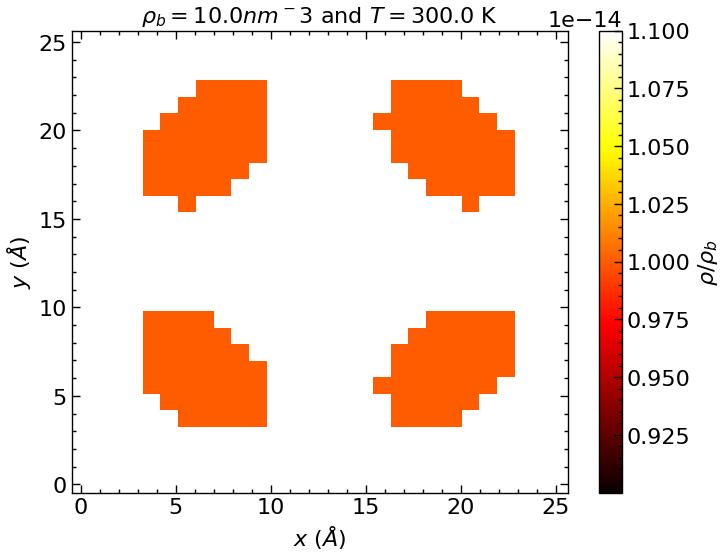

In [60]:
plt.figure(figsize=(8,6))
zz = Ngrid//2
c=plt.pcolormesh(DFTMMFA.X[:,:,zz],DFTMMFA.Y[:,:,zz],DFTMMFA.rho[:,:,zz].cpu()/DFTMMFA.rhob, cmap='hot')
plt.title(fr'$\rho_b = {DFTMMFA.rhob*1e3:.1f}nm^{-3} $ and $T = {kT:.1f}$ K')
plt.colorbar(label=r'$\rho/\rho_b$')
plt.xlabel(r'$x$ ($\AA$)')
plt.ylabel(r'$y$ ($\AA$)')
plt.show()

# Plotting the results

In [61]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')
exp_data2 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Duren2004.xls',sheet_name='IRMOF-1')
exp_data3 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Pillai2015.xls',sheet_name='IRMOF-1')
exp_data4 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Fu2015.xls',sheet_name='IRMOF-1')
exp_data5 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Keskin2016.xls',sheet_name='IRMOF-1')

In [62]:
helium_void_fraction = 0.852
Vpore = helium_void_fraction*Vcell

In [63]:
lines = [':','--','-']
names = ['MFA','WDA','MMFA']

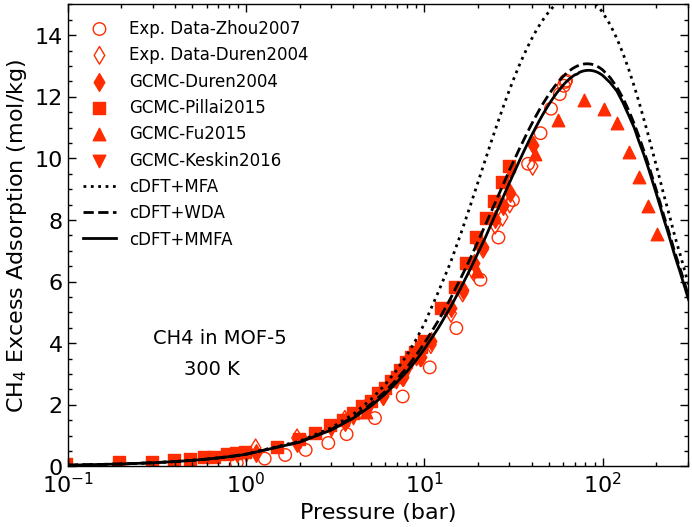

In [65]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['Pexc(bar)-300K'],(1e3/mss)*(mss/mff)*exp_data['Nexc(%wt)-300K']*0.01/(1-exp_data['Nexc(%wt)-300K']*0.01),marker='o',edgecolors='C3',facecolors='none',label='Exp. Data-Zhou2007')

plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='none',label='Exp. Data-Duren2004')
plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Sim Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='C3',label='GCMC-Duren2004')

#convert from absolute to excess
rhobarray_data3 = np.interp(exp_data3['Pressure (kPa)']/100, pbarray.numpy(), rhobarray.numpy())
Nabs_data3 = exp_data3['Absolute adsorption (mmol/g)']/(1e3/mss)
Nexc_data3 = Nabs_data3 - rhobarray_data3*Vpore
plt.scatter(exp_data3['Pressure (kPa)']/100,1e3*Nexc_data3/mss,marker='s',edgecolors='C3',facecolors='C3',label='GCMC-Pillai2015')

#convert from absolute to excess
rhobarray_data4 = np.interp(exp_data4['Pressure (bar)'], pbarray.numpy(), rhobarray.numpy())
Nabs_data4 = exp_data4['Absolute adsorption (cm^3 STP/cm^3)']/(1e30*(kB*298.15/101325)/Vcell) # Fu and Wu used 25ºC and 1 atm as STP?!!?!?
Nexc_data4 = Nabs_data4 - rhobarray_data4*Vpore
plt.scatter(exp_data4['Pressure (bar)'],1e3*Nexc_data4/mss,marker='^',edgecolors='C3',facecolors='C3',label='GCMC-Fu2015')

plt.scatter(exp_data5['Pressure (bar)'],exp_data5['Excess adsorption (mmol/g)'],marker='v',edgecolors='C3',facecolors='C3',label='GCMC-Keskin2016')

for d, DFT in enumerate(DFTs):
    plt.plot(pbarrange,Nexcarray[d]*1e3/mss,lines[d],color='k',label='cDFT+'+names[d])

plt.legend(loc='upper left',fontsize=12)
plt.xlabel('Pressure (bar)')
plt.ylabel('CH$_4$ Excess Adsorption (mol/kg)')
plt.xlim(0.1,300)
plt.ylim(0,15)
plt.text(0.3,4,'CH4 in MOF-5',fontsize=14)
plt.text(0.45,3,f'{kT:.0f} K',fontsize=14)
# plt.yscale('log')
plt.xscale('log')
plt.savefig('figures/CH4-MOF5-300K.png',dpi=300)